In [243]:
%matplotlib inline
# data manipulation libraries
import pandas as pd
import numpy as np

from time import time

# Graphs libraries
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn-v0_8-whitegrid')
import seaborn as sns



import plotly.express as px
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from plotly import tools

# Libraries to study
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import LFR, Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing, PrejudiceRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, EqOddsPostprocessing, RejectOptionClassification

# ML libraries
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

# Design libraries
from IPython.display import Markdown, display
import warnings
warnings.filterwarnings("ignore")

In [182]:
from aif360.datasets import MEPSDataset19

dataset_orig_panel19=MEPSDataset19()

In [183]:
sens_ind = 0
sens_attr = dataset_orig_panel19.protected_attribute_names[sens_ind]
unprivileged_groups = [{sens_attr: v} for v in
                    dataset_orig_panel19.unprivileged_protected_attributes[sens_ind]]
privileged_groups = [{sens_attr: v} for v in
                    dataset_orig_panel19.privileged_protected_attributes[sens_ind]]

### <a id="3.2">3.2 First models</a>

I'd like to remember that the goal of this Kernel is not to get a performant model, but the main goal is to find out how we can prevent bias on our model. So I will just construct a simple Random Forest model.

#### Split into train and test set

In [184]:
np.random.seed(42)

dataset_orig_panel19_train, dataset_orig_panel19_test = dataset_orig_panel19.split([0.7], shuffle=True)

#  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


display(Markdown("#### Train Dataset shape"))
print("Perpetrator Sex :",dataset_orig_panel19_train.features.shape)
display(Markdown("#### Test Dataset shape"))
print("Perpetrator Sex :",dataset_orig_panel19_test.features.shape)

#### Train Dataset shape

Perpetrator Sex : (11081, 138)


#### Test Dataset shape

Perpetrator Sex : (4749, 138)


#### Training the model : classic Random Forest

In [197]:
from sklearn.linear_model import LogisticRegression


In [198]:
# Train and save the models
rf_orig_sex = LogisticRegression().fit(dataset_orig_panel19_train.features, 
                     dataset_orig_panel19_train.labels.ravel(), 
                     sample_weight=dataset_orig_panel19_train.instance_weights)

### Predict on test set

In [199]:
X_test_sex = dataset_orig_panel19_test.features
y_test_sex = dataset_orig_panel19_test.labels.ravel()

In [196]:
# algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics', 'prediction', 'probs'])
# def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, preds, probs, name):
#     # Using loc to add a new row to the DataFrame directly
#     algo_metrics.loc[name] = [model, fair_metrics, preds, probs]
#     return algo_metrics


### PREETHI _ DONOT DELETE

### METRICS

In [254]:


def get_model_performance(X_test, y_true, y_pred, probs):
    accuracy = accuracy_score(y_true, y_pred)
    matrix = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)

    return accuracy, matrix, f1, fpr, tpr, roc_auc

def plot_confusion_matrix(matrix):
    plt.figure(figsize=(8, 6))
    
    sns.heatmap(matrix, annot=True, cmap='OrRd', fmt='g')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


def plot_roc_curve(fpr, tpr, roc_auc):
    fig = px.area(
        x=fpr, y=tpr,
        title=f'ROC curve ( Area = {roc_auc:.2f})',
        labels=dict(x='False Positive Rate', y='True Positive Rate'),
        width=600, height=600
    )

    fig.add_shape(
        type='line', line=dict(dash='dash', color='navy', width=2),
        x0=0, x1=1, y0=0, y1=1
    )


    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    fig.update_xaxes(constrain='domain')


    fig.add_vrect(x0=0, x1=0.5, fillcolor="red", opacity=0.1, line_width=0)  
    fig.add_vrect(x0=0.5, x1=1, fillcolor="green", opacity=0.1, line_width=0) 

    fig.show()








### ACCURACY and F1 SCORE

In [219]:
def model_performance(model, X_test, y_true):
    y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test)
    accuracy, matrix, f1, fpr, tpr, roc_auc = get_model_performance(X_test, y_true, y_pred, probs)

    display(Markdown('#### Accuracy of the model :'))
    print(accuracy)
    display(Markdown('#### F1 score of the model :'))
    print(f1)

model_performance(rf_orig_sex, dataset_orig_panel19_test.features, y_test_sex)


#### Accuracy of the model :

0.866919351442409


#### F1 score of the model :

0.5182926829268293


### ROC CURVE

In [249]:
def ROC_Plot(model, X_test, y_true):
    y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test)
    accuracy, matrix, f1, fpr, tpr, roc_auc = get_model_performance(X_test, y_true, y_pred, probs)

    plot_roc_curve(fpr, tpr, roc_auc)
    
ROC_Plot(rf_orig_sex, dataset_orig_panel19_test.features, y_test_sex)


### CONFUSION MATRIX

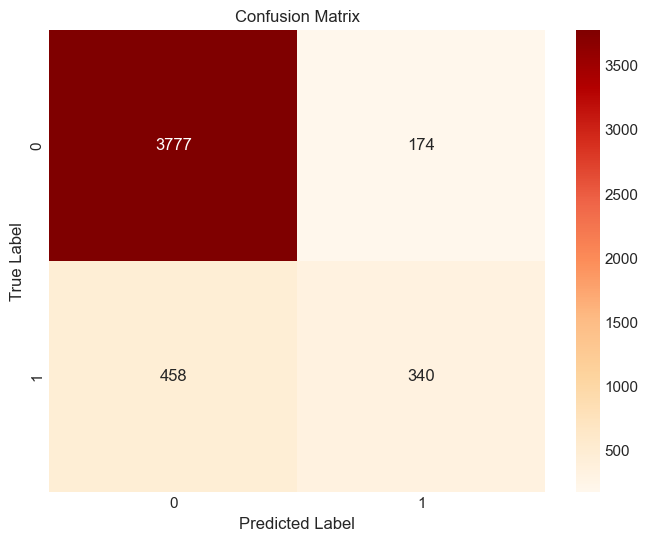

In [255]:
def Confusion_Matrix(model, X_test, y_true):
    y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test)
    accuracy, matrix, f1, fpr, tpr, roc_auc = get_model_performance(X_test, y_true, y_pred, probs)

    plot_confusion_matrix(matrix)
    
Confusion_Matrix(rf_orig_sex, dataset_orig_panel19_test.features, y_test_sex)

    

In [192]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display, Markdown

def plot_fair_metrics(fair_metrics):
    # Enhanced style settings
    sns.set(style="whitegrid", palette="muted")
    
    # Data preparation
    cols = fair_metrics.columns.values
    metrics_df = fair_metrics.iloc[1:]  # Exclude the 'objective' row for plotting
    objective_values = fair_metrics.loc['objective']

    # Plot setup
    fig, axs = plt.subplots(1, 5, figsize=(20, 5), sharey=True)
    colors = sns.color_palette("husl", n_colors=len(cols))

    # Plot each metric in a subplot
    for i, col in enumerate(cols):
        sns.barplot(x=metrics_df.index, y=metrics_df[col], ax=axs[i], palette=[colors[i]])
        
        # Add the objective line, ensuring it spans the full width of the plot
        xlim = axs[i].get_xlim()
        axs[i].plot(xlim, [objective_values[col]] * 2, 'r--', label='Objective')  # Adjusted to use plot for full width
        axs[i].set_xlim(xlim)  # Reset the xlim to ensure the plot is not altered by line plotting

        # Add shaded area for bounds
        bound = [-0.1, 0.1] if i < 3 else [0.8, 1.2] if i == 3 else [0, 0.25]
        axs[i].add_patch(patches.Rectangle((xlim[0], bound[0]), xlim[1] - xlim[0], bound[1] - bound[0], color='GREEN', alpha=0.2))

        # Set titles and labels
        axs[i].set_title(col.replace('_', ' ').title(), fontsize=16)
        axs[i].set_xlabel('')
        axs[i].set_ylabel('Metric Value' if i == 0 else '')

    # General layout adjustments
    plt.suptitle('Fairness Metrics Overview', fontsize=24, y=1.05)
    plt.tight_layout()
    plt.legend()

    # Display the plot
    plt.show()


fair_metrics
           statistical_parity_difference  equal_opportunity_difference  \
objective                       0.000000                      0.000000   
RACE                           -0.115925                     -0.181738   

           average_abs_odds_difference  disparate_impact  theil_index  
objective                     0.000000          1.000000     0.000000  
RACE                          0.110251          0.352207     0.115688  
<class 'pandas.core.frame.DataFrame'>


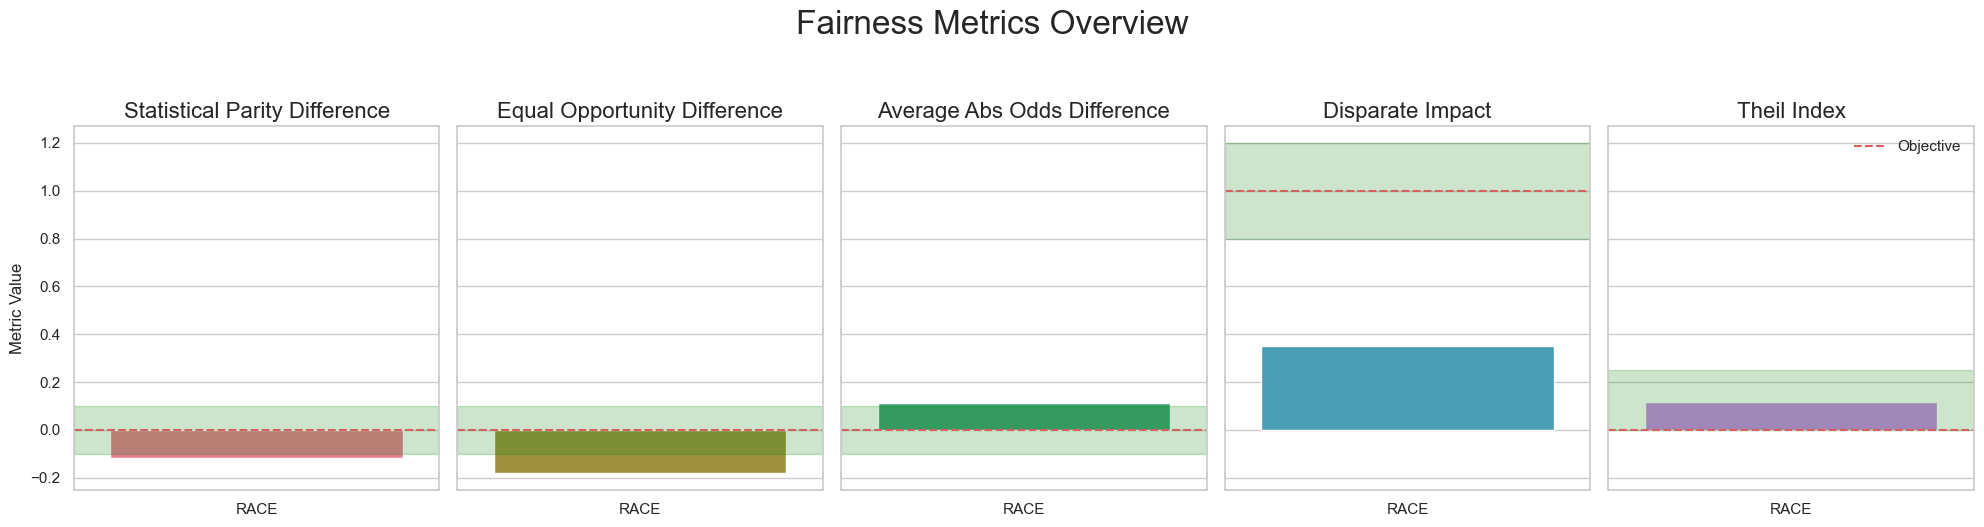

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
objective,0.000000,0.000000,0.000000,1.000000,0.000000
RACE,-0.115925,-0.181738,0.110251,0.352207,0.115688


In [194]:
import numpy as np
import pandas as pd
from aif360.metrics import ClassificationMetric, BinaryLabelDatasetMetric

def fair_metrics():
    dataset = dataset_orig_panel19_test
    pred = rf_orig_sex.predict(dataset.features)
    
    dataset_pred = dataset.copy()
    dataset_pred.labels = pred

    cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'average_abs_odds_difference', 'disparate_impact', 'theil_index']
    obj_fairness = [[0, 0, 0, 1, 0]]

    # Initialize DataFrame with objective row ---- Adjusted to initialize correctly
    fair_metrics = pd.DataFrame(data=obj_fairness, columns=cols, index=['objective'])
    
    rows_list = []  # Collect rows in a list for efficiency ---- Added for better performance

    for attr in dataset_pred.protected_attribute_names:
        idx = dataset_pred.protected_attribute_names.index(attr)
        privileged_groups = [{attr: dataset_pred.privileged_protected_attributes[idx][0]}]
        unprivileged_groups = [{attr: dataset_pred.unprivileged_protected_attributes[idx][0]}]

        classified_metric = ClassificationMetric(dataset, dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
        metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

        # Create a dictionary for the row ---- Simplified row creation
        row_dict = {
            'statistical_parity_difference': metric_pred.mean_difference(),
            'equal_opportunity_difference': classified_metric.equal_opportunity_difference(),
            'average_abs_odds_difference': classified_metric.average_abs_odds_difference(),
            'disparate_impact': metric_pred.disparate_impact(),
            'theil_index': classified_metric.theil_index()
        }
        
        rows_list.append(row_dict)  # Append dictionary to list ---- Efficient collection of rows

    # Convert list of dicts to DataFrame and concatenate with the objective row ---- Proper use of pd.concat
    if rows_list:
        new_rows_df = pd.DataFrame(rows_list, index=dataset_pred.protected_attribute_names)
        fair_metrics = pd.concat([fair_metrics, new_rows_df])

    fair_metrics = fair_metrics.replace([-np.inf, np.inf], 2)  # Handle infinite values

    print('fair_metrics')
    print(fair_metrics)
    print(type(fair_metrics))

    return fair_metrics

fair = fair_metrics()

# Assuming plot_fair_metrics function exists and is correct ---- No changes made here
plot_fair_metrics(fair)
display(fair)


### PREETHI _ UNTIL THIS